In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torchaudio
from scipy import signal
import torch
from torch.utils.data import DataLoader

from ipywidgets import interactive
from IPython.display import Audio, display

## TorchAudio SPEECHCOMMANDS Dataset

In [2]:
ds = torchaudio.datasets.SPEECHCOMMANDS("data", download=True)

In [3]:
len(ds)

105829

In [4]:
waveform, sample_rate, utterance, speaker_id, utterance_id = ds[10]
waveform, sample_rate, utterance, speaker_id, utterance_id

(tensor([[-3.0518e-05,  9.1553e-05,  1.8311e-04,  ..., -1.5259e-04,
          -1.2207e-04, -1.2207e-04]]),
 16000,
 'eight',
 '0cb74144',
 2)

In [5]:
waveform.shape

torch.Size([1, 16000])

In [6]:
display(Audio(data=waveform, rate=sample_rate))

(129,) (71,) (129, 71)


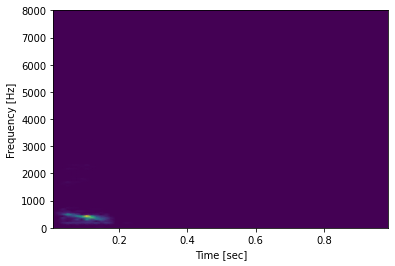

In [7]:
f, t, Sxx =signal.spectrogram(waveform.view(-1), fs=sample_rate)
print(f.shape, t.shape, Sxx.shape)
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

## CinC2020 Dataset

In [8]:
from datasets import CinC2020

In [9]:
ds = CinC2020(set_seq_len=5000)
p_signal, sampling_rate, age, sex, dx = ds[0]
p_signal, sampling_rate, age, sex, dx

(array([[ 0.   ,  0.01 ,  0.01 , ...,  0.075,  0.016,  0.009],
        [ 0.   ,  0.012,  0.013, ...,  0.103,  0.018,  0.009],
        [ 0.   ,  0.011,  0.012, ...,  0.089,  0.013,  0.004],
        ...,
        [-0.013, -0.001,  0.012, ...,  0.107,  0.002,  0.003],
        [-0.008,  0.004,  0.012, ...,  0.104,  0.006,  0.002],
        [-0.01 ,  0.007,  0.018, ...,  0.121,  0.008,  0.003]]),
 500,
 53.0,
 0.0,
 164867002)

In [10]:
display(Audio(data=p_signal[:,0], rate=sampling_rate))

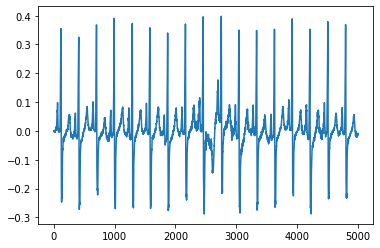

In [11]:
plt.plot(p_signal[:, 0])
plt.show()

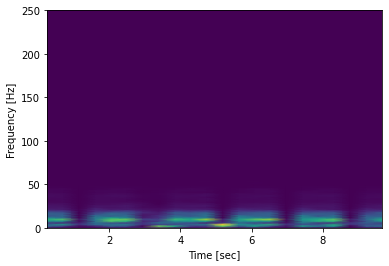

In [12]:
f, t, Sxx =signal.spectrogram(p_signal[:, 0], fs=sampling_rate)
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [13]:
p_signal, sampling_rate, age, sex, dx = next(iter(DataLoader(ds, batch_size=16)))

p_signal.shape, sampling_rate, age, sex, dx

(torch.Size([16, 5000, 12]),
 tensor([500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500,
         500, 500]),
 tensor([53., 70., 70., 55., 55., 57., 51., 51., 51., 51., 51., 20., 20., 20.,
         54., 72.], dtype=torch.float64),
 tensor([0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
        dtype=torch.float64),
 tensor([164867002, 164861001, 164861001, 164867002, 164867002, 164861001,
         428750005, 428750005, 428750005, 428750005, 428750005, 428750005,
         428750005, 428750005, 428750005, 427172004]))

In [32]:
class Encoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(Encoder, self).__init__()
        self.seq_len = seq_len
        self.n_features = n_features
        self.embedding_dim = embedding_dim
        self.hidden_dim = 2 * embedding_dim

        self.rnn1 = nn.LSTM(
          input_size=n_features,
          hidden_size=self.hidden_dim,
          num_layers=1,
          batch_first=True
        )
        self.rnn2 = nn.LSTM(
          input_size=self.hidden_dim,
          hidden_size=embedding_dim,
          num_layers=1,
          batch_first=True
        )

    def forward(self, x):
        x, (_, _) = self.rnn1(x)
        x, (hidden_n, _) = self.rnn2(x)
        # print(x.shape, hidden_n.shape)
        # return hidden_n.reshape((self.n_features, self.embedding_dim))
        hidden_n = torch.transpose(hidden_n, 0, 1)
        # hidden_n.shape == (16, 1, 64)
        return hidden_n

# print(p_signal.dtype)
enc_m = Encoder(seq_len=5000, n_features=12)
enc_m.double()
print("Encode in: ", p_signal.shape)
x = enc_m(p_signal)
print("Encode out: ", x.shape)


Encode in:  torch.Size([16, 5000, 12])
Encode out:  torch.Size([16, 1, 64])


In [37]:
class Decoder(nn.Module):

    def __init__(self, seq_len, input_dim=64, n_features=1):
        super(Decoder, self).__init__()
        self.seq_len, self.input_dim = seq_len, input_dim
        self.hidden_dim, self.n_features = 2 * input_dim, n_features

        self.rnn1 = nn.LSTM(
          input_size=input_dim,
          hidden_size=input_dim,
          num_layers=1,
          batch_first=True
        )

        self.rnn2 = nn.LSTM(
          input_size=input_dim,
          hidden_size=self.hidden_dim,
          num_layers=1,
          batch_first=True
        )
        self.output_layer = nn.Linear(self.hidden_dim, n_features)

    def forward(self, x):
        x = x.repeat(1, self.seq_len, 1)
        print(x.shape)
        x, (hidden_n, cell_n) = self.rnn1(x)
        print(x.shape)
        x, (hidden_n, cell_n) = self.rnn2(x)
        print(x.shape)
        x = x.reshape((self.seq_len, self.hidden_dim))
        return self.output_layer(x)

dec_m = Decoder(seq_len=5000, n_features=12)
dec_m.double()
print("Decode in: ", x.shape)
y = dec_m(x)
print("Decode out: ", y.shape)

Decode in:  torch.Size([16, 1, 64])
torch.Size([16, 5000, 64])
torch.Size([16, 5000, 64])
torch.Size([16, 5000, 128])


RuntimeError: shape '[5000, 128]' is invalid for input of size 10240000

## MNIST

In [14]:
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

In [15]:
mnist = MNIST("data", train=True, download=True, transform=ToTensor())
len(mnist)

60000

In [16]:
img_tensor, label = mnist[0]
img_tensor.shape, label

(torch.Size([1, 28, 28]), 5)

In [17]:
next(iter(DataLoader(mnist,  batch_size=16)))

[tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         ...,
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ..